In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import joblib

In [9]:

# Load dataset from CSV
mfcc_data = pd.read_csv('Ekstraksi_MFCC.csv')

# Extract features and labels
X = mfcc_data.iloc[:, 1:-1].values  # Assuming MFCC features are in columns 1 to second last
y = mfcc_data.iloc[:, -1].values   # Assuming labels are in the last column

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1

accuracy_per_fold = []
loss_per_fold = []

# Define a function to build the model
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

for train_index, test_index in kf.split(X):
    print(f"Training fold {fold_no}...")
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

    # Reshape data to fit LSTM input requirements (samples, timesteps, features)
    X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Build the LSTM model
    model_lstm = build_model((1, X_train_lstm.shape[2]), y_categorical.shape[1])

    # Train the LSTM model
    history_lstm = model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

    # Evaluate the LSTM model
    loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test_lstm, y_test, verbose=0)
    print(f"Fold {fold_no} - Loss: {loss_lstm} - Accuracy: {accuracy_lstm}")
    
    accuracy_per_fold.append(accuracy_lstm)
    loss_per_fold.append(loss_lstm)
    
    fold_no += 1
    
# Print average accuracy and loss over all folds
print(f"Average Loss: {np.mean(loss_per_fold)}")
print(f"Average Accuracy: {np.mean(accuracy_per_fold)}")

Training fold 1...


c:\Users\Tun Pasek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5272 - loss: 1.2590 - val_accuracy: 0.7981 - val_loss: 0.5392
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8361 - loss: 0.4423 - val_accuracy: 0.9094 - val_loss: 0.2702
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9035 - loss: 0.2670 - val_accuracy: 0.9381 - val_loss: 0.1947
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9300 - loss: 0.1924 - val_accuracy: 0.9456 - val_loss: 0.1679
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9365 - loss: 0.1795 - val_accuracy: 0.9475 - val_loss: 0.1482
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9492 - loss: 0.1547 - val_accuracy: 0.9519 - val_loss: 0.1402
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9486 - loss: 0.1401 - val_accuracy: 0.9556 - val_loss: 0.1369
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9465 - loss: 0.1367 - val_accuracy: 0.

In [13]:
# Print accuracy for each fold
print("\nAccuracy for each fold:")
for i, accuracy in enumerate(accuracy_per_fold, 1):
    print(f"Fold {i}: Accuracy = {accuracy}")

# Print average accuracy
print(f"\nAverage Accuracy: {np.mean(accuracy_per_fold)}")


Accuracy for each fold:
Fold 1: Accuracy = 0.9706249833106995
Fold 2: Accuracy = 0.9756249785423279
Fold 3: Accuracy = 0.9762499928474426
Fold 4: Accuracy = 0.9806249737739563
Fold 5: Accuracy = 0.9775000214576721

Average Accuracy: 0.9761249899864197


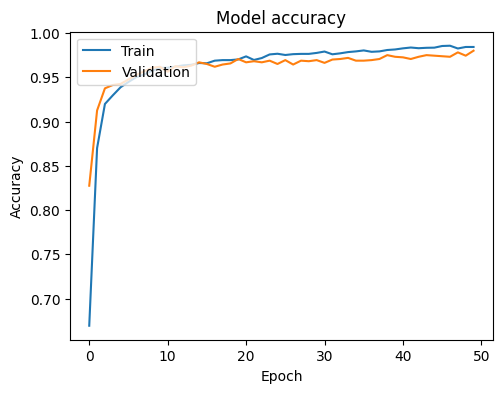

In [7]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


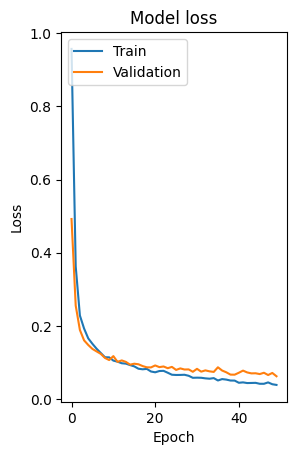

In [8]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


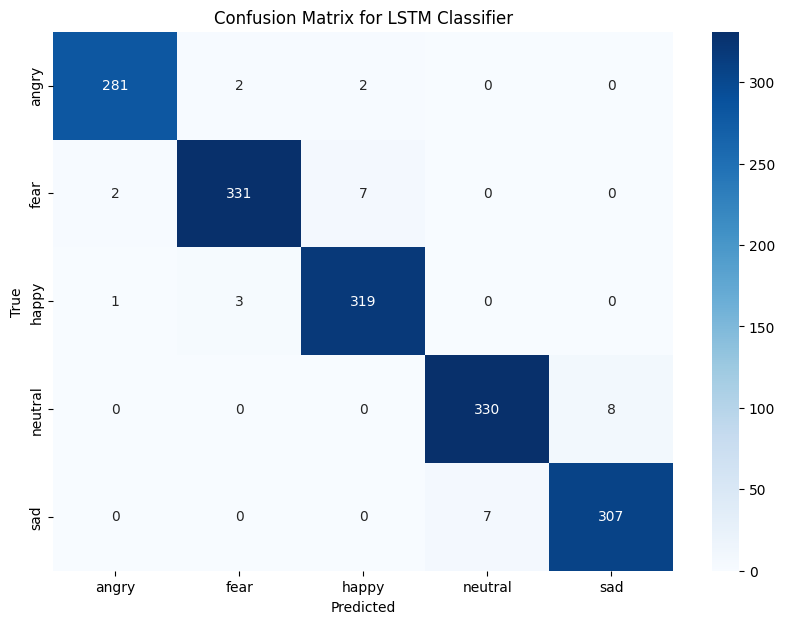

Classification Report:
              precision    recall  f1-score   support

       angry       0.99      0.99      0.99       285
        fear       0.99      0.97      0.98       340
       happy       0.97      0.99      0.98       323
     neutral       0.98      0.98      0.98       338
         sad       0.97      0.98      0.98       314

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



In [9]:
# Predict on test set for the last fold
y_pred = model_lstm.predict(X_test_lstm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LSTM Classifier')
plt.show()

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)


In [14]:
joblib.dump(scaler, 'scaler.pkl')

# Save the model
model_lstm.save('emotion_model.h5')
